# 于巴西未前往就诊的挂号预约探讨

## Table of Contents
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#question">提出问题</a></li>
<li><a href="#wrangling">数据收集和整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">总结</a></li>
</ul>

<a id='intro'></a>
## 简介

本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。

<a id="question"></a>
## 提出问题

数据中除了预约日期、预约的就诊日期、年龄、街区、是否有福利保障外尚有慢性病如高血压、糖尿病、酗酒或行动不便者及简讯通知与否，试着透过这些参数分析与是否前往就诊有无显着关系。

**问题 1**:统计男女预约就诊率比例的差异<br>
**问题 2**:统计福利保障人群是的预约就诊率比例于非福利保障人群的不同<br>
**问题 3**:分析年龄是否是预约就诊率明显变因之一<br>
**问题 4**:慢性病者(高血压、糖尿病)、酗酒、行动不便者或简讯通知的预约就诊率比例<br>

<a id='wrangling'></a>
## 数据收集和整理


In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pp
file_path  =  './KaggleV2-May-2016.csv'
df = pd.read_csv(file_path)
df.head(2)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [2]:
print("是否有缺资料:{}".format(df.isnull().any().any()))
print(df.columns)
print('Age data type: {}'.format(set(df['Age'])))
print('Scholarship data type: {}'.format(set(df['Scholarship'])))
print('Hipertension data type: {}'.format(set(df['Hipertension'])))
print('Diabetes data type: {}'.format(set(df['Diabetes'])))
print('Alcoholism data type: {}'.format(set(df['Alcoholism'])))
print('Handcap data type: {}'.format(set(df['Handcap'])))

是否有缺资料:False
Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')
Age data type: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115, -1}
Scholarship data type: {0, 1}
Hipertension data type: {0, 1}
Diabetes data type: {0, 1}
Alcoholism data type: {0, 1}
Handcap data type: {0, 1, 2, 3, 4}


'Age'的资料有小于0的资料类型，过滤不合理的数据，其他的如Scholarship、Hipertension、Diabetes、Alcoholism及Handcap，观察无不合理数据。

In [3]:
df= df[df.Age >= 0]
print('Age data type: {}'.format(set(df['Age'])))

Age data type: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115}


**问题 1** :统计男女就诊比例的差异

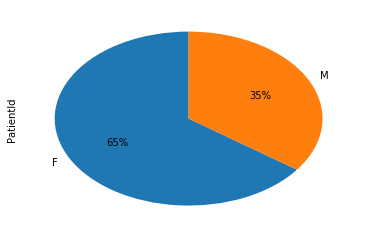

In [4]:
df['show_bool'] = df['No-show'].map({'Yes':0, 'No':1})
gender_show = df.groupby('Gender')['PatientId'].count()
gender_show.plot(kind = 'pie', startangle = 90, autopct = '%.0f%%')

Gender
F    0.796851
M    0.800321
Name: show_bool, dtype: float64


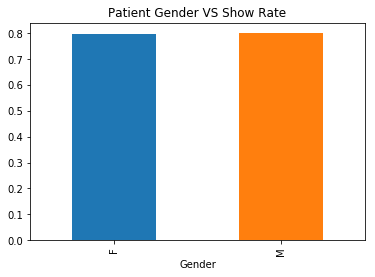

In [5]:
gender_ratio = df.groupby('Gender')['show_bool'].mean()
print(gender_ratio)
gender_ratio.plot(kind = 'bar', title = 'Patient Gender VS Show Rate')

**答案 1** : 经统计结果观察女性预约看诊的人数约是男性看诊的两倍，然而预约就诊率的比例相当接近，皆约80%，无明显统计差异，因此单就性别无法当作预测就诊率的指标。

**问题 2** :统计福利保障人群是的预约就诊率比例于非福利保障人群的不同

<bound method Series.unstack of scholarship_bool  show_bool
N                 0            19741
                  1            79924
Y                 0             2578
                  1             8283
Name: PatientId, dtype: int64>

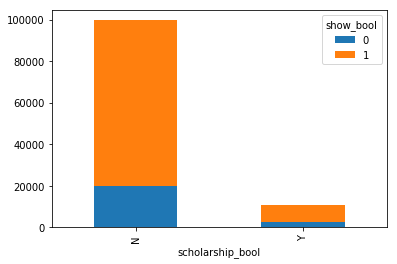

In [6]:
df['scholarship_bool']= df['Scholarship'].map({1:'Y', 0:'N'})
scholar_show = df.groupby(['scholarship_bool','show_bool'])['PatientId'].count()
scholar_show.unstack().plot(kind = 'bar', stacked = 'True')
scholar_show.unstack

scholarship_bool
N    0.801926
Y    0.762637
Name: show_bool, dtype: float64


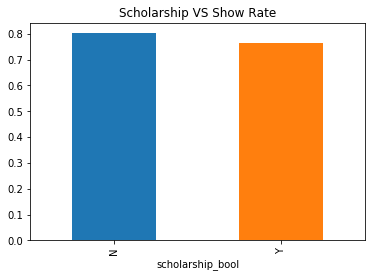

In [7]:
scholar_ratio = df.groupby('scholarship_bool')['show_bool'].mean()
print(scholar_ratio)
scholar_ratio.plot(kind = 'bar', title = 'Scholarship VS Show Rate')

**答案 2** :观察统计结果，拥有福利保障人数明显远小于无福利保障的人数，约是无福利保障人数的四分之一，然而无福利保障的人群预约就诊率明显略低于拥有福利保障的人群，其可列为预测参数之一。

**问题 3**:分析年龄是否是预约就诊率明显变因之一

In [8]:
age_level_list = [ 10, 20, 30, 40, 50, 60, 70 ]
age_level_string = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-']
age_levels = []

for row in df['Age']:
    i = 0    
    while i < len(age_level_list) and row > age_level_list[i]:
        i += 1
    level = age_level_string[i]
    age_levels.append(level)

df['AgeLevel'] = age_levels

AgeLevel
0-9      18749
10-19    13099
20-29    13783
30-39    15052
40-49    14420
50-59    15661
60-69    11189
70-       8573
Name: PatientId, dtype: int64

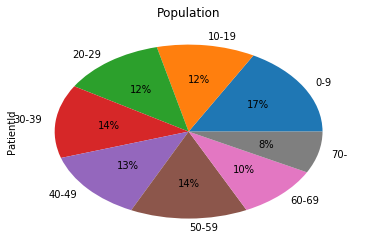

In [9]:
group_age_level = df.groupby('AgeLevel')['PatientId'].count()
group_age_level.plot(kind = 'pie' , title = 'Population', autopct = '%.0f%%')
group_age_level

AgeLevel
0-9      0.797963
10-19    0.747462
20-29    0.753755
30-39    0.785278
40-49    0.800971
50-59    0.826256
60-69    0.852712
70-      0.841596
Name: show_bool, dtype: float64

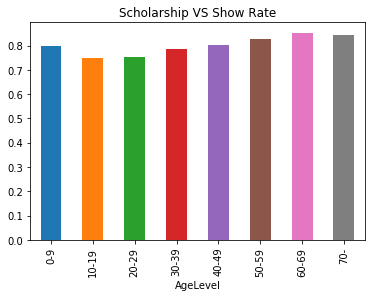

In [10]:
age_level_ratio = df.groupby('AgeLevel')['show_bool'].mean()
age_level_ratio.plot(kind = 'bar', title = 'Scholarship VS Show Rate')
age_level_ratio

**答案 3** : 統計趨勢觀察起來，不足十岁的儿童占最大的看诊人群，可能身体属于发展阶段，抵抗力相较比较差，而也是家长较为谨慎的年记，随着身体发育，10至29岁这阶段，身体相较比较好，所以看诊人数及就诊率明显都较低，就诊人数30到59这个阶段，人数较接近，而就诊率则为微幅上升，60至69歲這個區間的就診人数就明显较少，但预约就诊率最高，統計上年龄可列為觀察指標之一。

**问题 4** :慢性病者(高血压、糖尿病)、酗酒或行动不便者的预约就诊率比例

In [1]:
series_handicap = []
def handicap_fun(data):
    result = 0
    if data > 0:
        result = 1
    return result
#df['IsHandcap'] = df['Handcap'].apply(handicap_fun)
df['IsHandcap'] = (df['Handcap'] > 0).astype(int)

NameError: name 'df' is not defined

In [12]:
column_list = ['Hipertension', 'Diabetes', 'Alcoholism','IsHandcap','SMS_received']
column_name = ['Hipertension', 'Diabetes', 'Alcoholism','Handcap','SMS_received']
static_dic = {}
for item in column_list:
    _df = df.groupby(item)['show_bool']
    _count = _df.count()
    _mean = _df.mean()
    _sta = {'count': _count, 'mean':_mean}
    static_dic[item] = _sta

In [13]:
def draw_plot(_column, _dic, _item, _title, _xticks):
    _0_list = []
    _1_list = []
    for item in column_list:
        _0_list.append(_dic[item][_item][0])
        _1_list.append(_dic[item][_item][1])
    N = len(_0_list) 
    ind =  np.arange(N) 
    width = 0.35
    fig, ax = plt.subplots()
    p1 = ax.bar(ind, _1_list, width, color='r', bottom = 0.0)
    p2 = ax.bar(ind + width, _0_list , width,color='y', bottom=0)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(column_name)
    ax.legend((p1[0], p2[0]), _xticks)
    fig.suptitle(_title , fontsize=14, fontweight='bold')

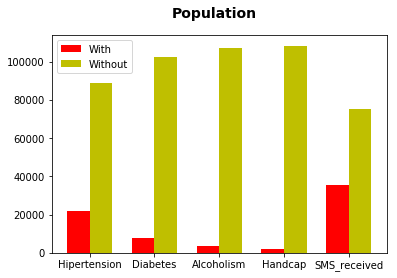

In [14]:
xticks = ('With', 'Without')
title = 'Population'
draw_plot(column_list, static_dic, 'count', _xticks = xticks, _title = title)

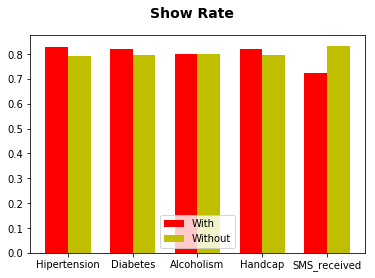

In [15]:
xticks = ('With', 'Without')
title = 'Show Rate'
draw_plot(column_list, static_dic, 'mean', _xticks = xticks, _title = title )

**答案 4** : 高血压及简讯通知人数上较多，因此统计上参考性较高，观察结果高血压患者就诊率明显略高于非高血压患者；而简讯通知者反而报到就诊率较无简讯通知者低，简讯的通知对就诊率无帮助。

<a id='conclusions'></a>
## 总结
根据巴西预约挂号数据分析男女不同性别人数上有显注的差异，女性就诊人数明显高于男性就诊，造成此人数上的明显差异可能要需要其他数据一同分析探讨，如当然就业机会是否较低，或是女性就业机会较高，导致男性至外地工作等因素；就诊率而言性别并无明显差异。福利保障人群是属于少数比例民众的权利，然而就诊率确明显较低，可能福利保障使得民众相较不重视此医疗资源，其符合一般常理。年龄层的不同人数上亦有不同的驱势，不足十岁的儿童占最大的看诊人数，其就诊率亦有所明显差异，不足十岁的儿童就诊率是相较较高，而10至29岁的年龄层最低，可能年纪较轻对于看健建较不担心，随着年龄增长开始重视健康，到60至69就诊率最高，而70以上可能行动上较不方便所以略降。最后通知患有疾病患者的就诊率就人数上高血压患者及简讯通知道的统计人数较充足，具有较高的参考性，高血压患者的就诊率是较无高血压患者的就诊率高一些，其中比较违反常理的是简讯的通知反而对就诊率的帮助是反向的。

此份报告是由巴西预约挂号数据分析，其无就诊医院的相关资料，如医院的设备及民众看诊的项目，医院设备越齐全，民众前往的意愿会较高，然而亦可能导致更高的看诊费用，导致降低民众的意愿。医院的位置和民众的居住地亦有一定的相依性，路途过于遥远或是医院周边交通的便利性亦是影响民众前往的意愿，另外天气亦可能是影响赴约的意愿，这些因素亦是可以探讨的方向